## HarvestStat Data Profiling - Somalia

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32639' # Somalia
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/SO_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Somalia',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1990	 | SO1990A1 | 18	| SO1990A2	| 74	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_2'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(',')[0])
# b) Control population groups
# Data of Awdal (SO1990A111) prior to 2017 has a population group (Borama (SO1990A21109) and Baki (SO1990A21102))
# This is not duplicated data, so we will link the data with an exception for one duplicated data point:
df = df[df['id'] != 3831320]
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Harvested')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([SO_Admin1_1990, SO_Admin2_1990], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 25,919
Removed 3,667 "Missing Value" points
6,249/6,480 "Area Harvested" points are retained.
3,676/6,479 "Area Planted" points are retained.
6,190/6,480 "Quantity Produced" points are retained.
6,137/6,480 "Yield" points are retained.
Current data points: 22,252

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1982 - 2022
10 grain types are found: Cowpeas (Mixed), Groundnuts (In Shell), Maize (Corn), Onions, Pepper (Piper spp.), Rice (Paddy), Sesame Seed, Sorghum, Tomato, Watermelon
4 seasons are found: Gu (07-01), Deyr (02-01), Gu off-season (09-01), Deyr off-season (03-01)
3 crop production system are found: agro_pastoral, none, riverine
Data sources include:
[1] FSNAU, Somalia --- FSNAU, Somalia
Administrative-1 fnids: 14
Administrative-2 fnids: 47
2 reporting units are found: SO1990R22805, SO1990R22806

- Total production over time -------------

- Somalia crop seasonal calendar </br>

![FEWS NET](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-somalia.png?itok=raaT51aR)

- FDW data consists of `SO1990A1` and `SO1990A2`.

| Year | Admin-1 | # units | Admin-2  | # units |
| :--- | :----:  | :----:  | :----:   | ---:    |
| 1990 | SO1990A1| 18      | **`SO1990A2`** | 74      |

- Comparison between admin boundaries.

![image](https://github.com/chc-ucsb/gscd/blob/main/figures/SO_admin_shapes.png?raw=true)

<!-- - Most of reliable data are admin-2 level, and FDW has few data for admin-1 level. Therefore, we aggregate/merge admin-2 level data to represent admin-1 level. -->
- Afmadow (SO1990A22802) has two crop reporting units: Afmadow (SO1990R22805) and Afmadow (Hagar) (SO1990R22806). Since SO1990A22802 has only one off-season record, we aggregate SO1990R22805 and SO1990R22806 to replace SO1990A22802.

| District |Crop reporting units|
| :---:|:---:|
|Afmadow (SO1990A22802) | Afmadow (SO1990R22805) and  Hagar (SO1990R22806)|

- **`SO1990A2`** is used to represent the current admin-level 2 crop data.
- Somalia has 4 crop seasons: `Deyr`, `Gu`, `Gu off-season`, `Deyr off-season`.
- Somalia has 3 crop production systems: `agro_pastoral`, `riverine`, `None`.
- Somalia has 0 population group.

In Admin-2 level data, we found unrealistic records. So, we manually remove those records:
- 26 districts have the exactly same `1 mt/ha` yield values in `Deyr` season of `2001`.
- Three districts have unrealistic yield values in `Gu` season of `2005`: Bu'aale (11.65 mt/ha), Jilib (2.27 mt/ha), and Saakow (20.8 mt/ha).

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = SO_Admin2_1990.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
df['season_name'] = df['season_name'].replace({'Gu off-season':'Gu-off', 'Deyr off-season':'Deyr-off'})
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [5]:
# Link admin boundaries ------------------------- #
link, over = FDW_PD_CreateAdminLink(SO_Admin2_1990, SO_Admin2_1990, 'ADMIN2', 'ADMIN2', prod, epsg)
# Crop specific ratios
link_ratio = FDW_PD_RatioAdminLink(link, prod, over, mdx_pss)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Manual Editing
link_ratio['SO1990A22802'][['SO1990R22805', 'SO1990R22806']] = 1.0
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

CBR is considered for 'SO1990A21604' as no record found in: ['SO1990A21604']
CBR is considered for 'SO1990A21202' as no record found in: ['SO1990A21202']
CBR is considered for 'SO1990A21102' as no record found in: ['SO1990A21102']
CBR is considered for 'SO1990A21703' as no record found in: ['SO1990A21703']
CBR is considered for 'SO1990A21802' as no record found in: ['SO1990A21802']
CBR is considered for 'SO1990A21103' as no record found in: ['SO1990A21103']
CBR is considered for 'SO1990A21603' as no record found in: ['SO1990A21603']
CBR is considered for 'SO1990A21605' as no record found in: ['SO1990A21605']
CBR is considered for 'SO1990A21104' as no record found in: ['SO1990A21104']
CBR is considered for 'SO1990A21601' as no record found in: ['SO1990A21601']
CBR is considered for 'SO1990A21503' as no record found in: ['SO1990A21503']
CBR is considered for 'SO1990A21502' as no record found in: ['SO1990A21502']
CBR is considered for 'SO1990A21606' as no record found in: ['SO1990A21606']

In [6]:
# Manual correction ----------------------------- #
# - Remove data before 1995
area_new = area_new.loc[1995:]
prod_new = prod_new.loc[1995:]
crop_new = prod_new/area_new
# - Unrealistic values in 2005 in Gu season
target = ['SO1990A22701','SO1990A22702','SO1990A22703']
area_new.loc[2005,pd.IndexSlice[target,:,'Maize (Corn)','Gu',:]] = np.nan
prod_new.loc[2005,pd.IndexSlice[target,:,'Maize (Corn)','Gu',:]] = np.nan
crop_new.loc[2005,pd.IndexSlice[target,:,'Maize (Corn)','Gu',:]] = np.nan
# # - Districts have the same 1 mt/ha yield records in 2001 in Deyr season
# temp = crop_new.loc[2001, pd.IndexSlice[:,:,'Maize (Corn)','Deyr']]
# target = temp.index.get_level_values(0)[temp == 1]
# area_new.loc[2001,pd.IndexSlice[target,:,'Maize (Corn)','Deyr',:]] = np.nan
# prod_new.loc[2001,pd.IndexSlice[target,:,'Maize (Corn)','Deyr',:]] = np.nan
# crop_new.loc[2001,pd.IndexSlice[target,:,'Maize (Corn)','Deyr',:]] = np.nan
# # - Unrealistic values in 1995 in Dery season
# target = ['SO1990A22605']
# area_new.loc[1995,pd.IndexSlice[target,:,'Maize (Corn)','Deyr',:]] = np.nan
# prod_new.loc[1995,pd.IndexSlice[target,:,'Maize (Corn)','Deyr',:]] = np.nan
# crop_new.loc[1995,pd.IndexSlice[target,:,'Maize (Corn)','Deyr',:]] = np.nan
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Cowpeas (Mixed)': 'Cowpeas',
    'Groundnuts (In Shell)': 'Groundnuts (In Shell)', 
    'Maize (Corn)': 'Maize',
    'Onions': 'Onions', 
    'Rice (Paddy)': 'Rice', 
    'Sesame Seed': 'Sesame Seed', 
    'Sorghum': 'Sorghum', 
    'Tomato': 'Tomato',
    'Watermelon': 'Watermelon'
}
stack['product'] = stack['product'].replace(product_category_custom)
for f, r in link_ratio.items():
    mdx = pd.MultiIndex.from_frame(r.index.to_frame().reset_index(drop=True).replace(product_category_custom))
    r.index = mdx
    link_ratio[f] = r
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Somalia']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

# Save data
fn_out = '../data/crop/adm_crop_production_SO.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_SO_ratio.npz', link_ratio)

All [season_name, product, crop_production_system] are in the external crop calendar.
../data/crop/adm_crop_production_SO.csv is saved.
../data/crop/adm_crop_production_SO_ratio.npz is saved.


# Visualization of production data

../figures/SO_bar_natgrainprod_Gu.png is saved.


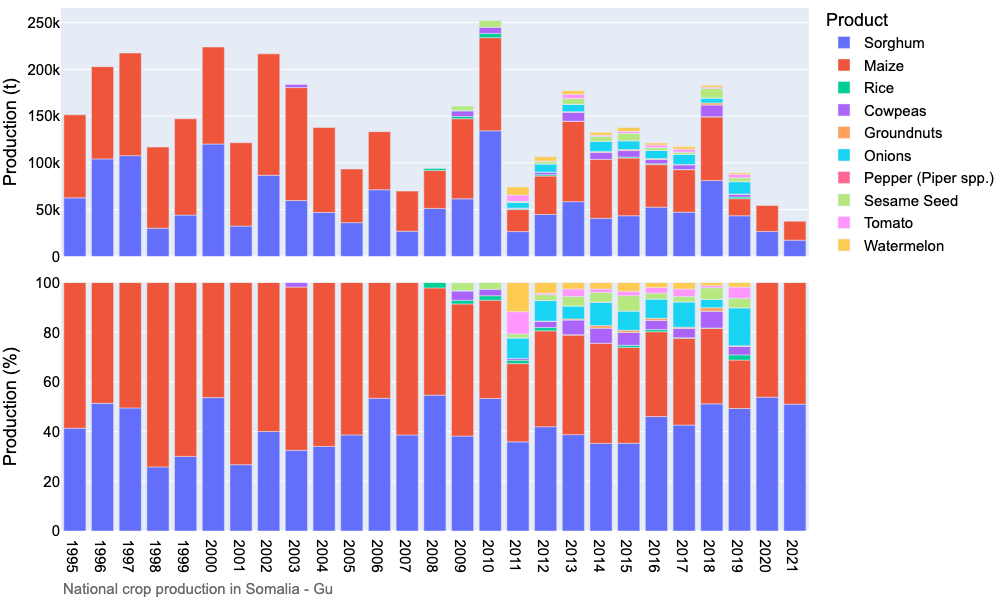

../figures/SO_bar_natgrainprod_Deyr.png is saved.


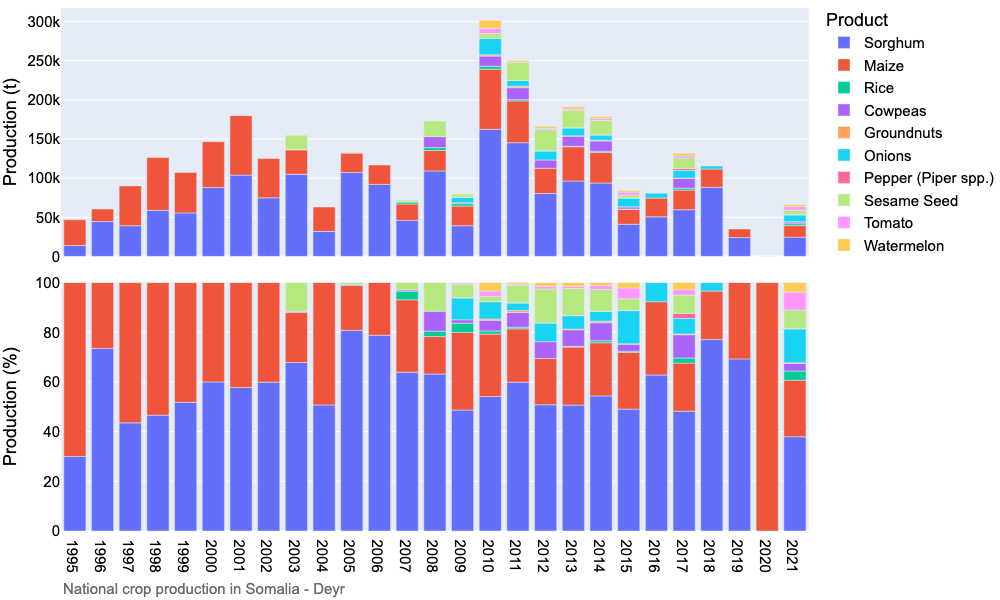

In [7]:
# Bar chart of national crop production
country_iso, country_name = 'SO', 'Somalia'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [1995, df['year'].max()]
product_order = ['Sorghum','Maize','Rice']
for season_name in ['Gu','Deyr']:
    footnote = 'National crop production in %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()

../figures/SO_lineplot_Maize_Gu.png is saved.


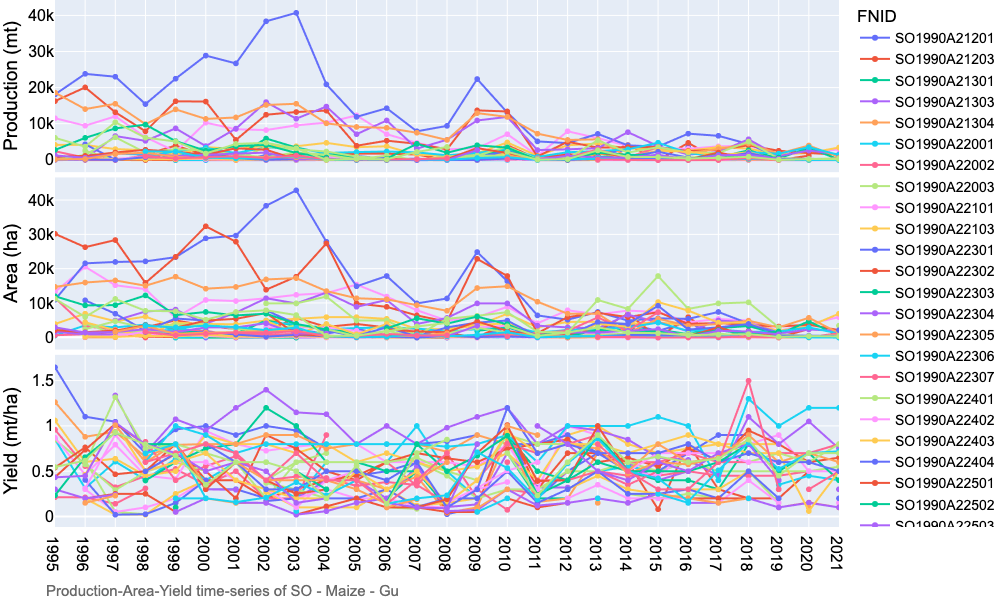

../figures/SO_lineplot_Maize_Deyr.png is saved.


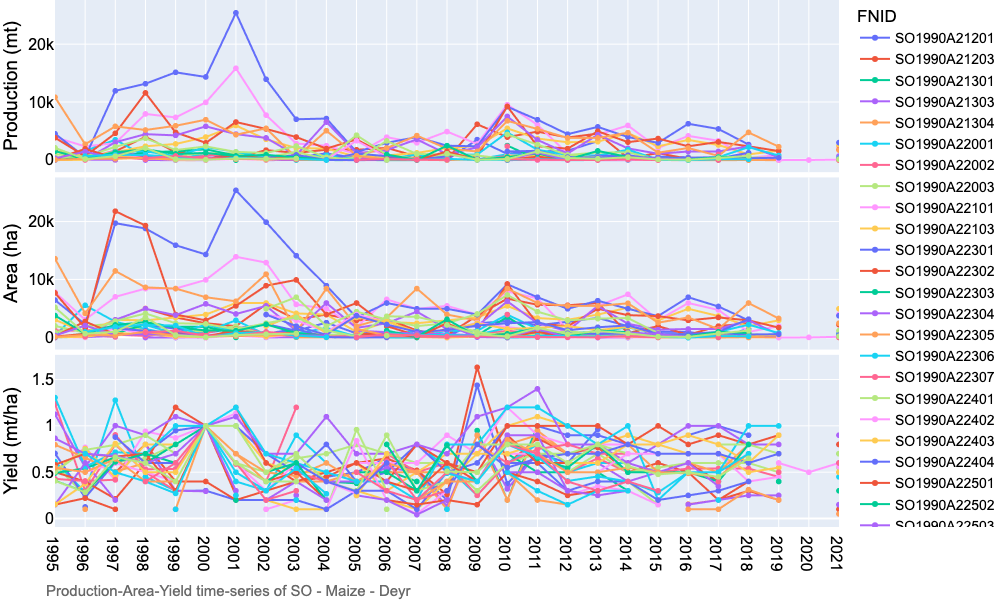

../figures/SO_lineplot_Sorghum_Gu.png is saved.


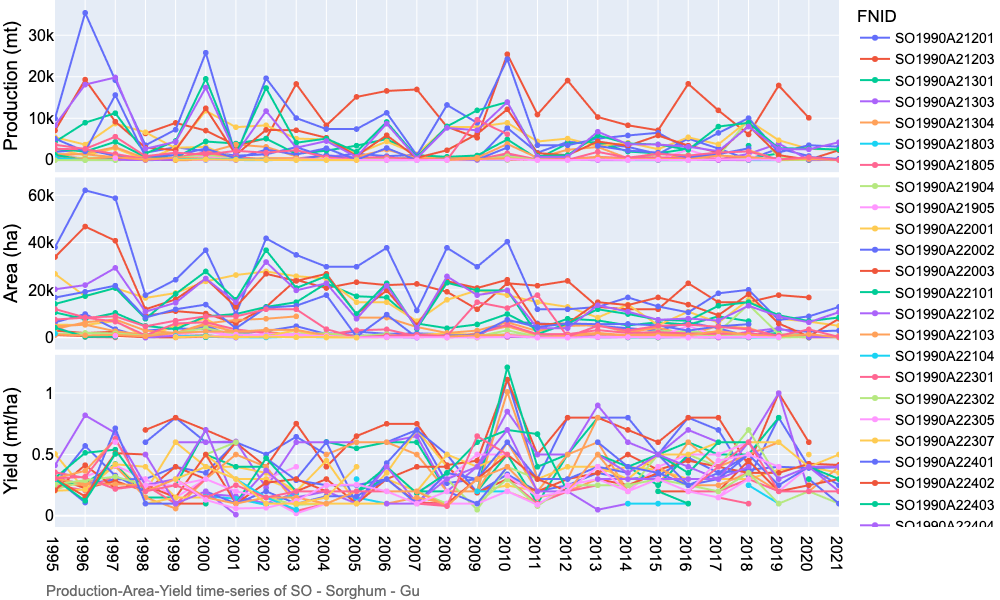

../figures/SO_lineplot_Sorghum_Deyr.png is saved.


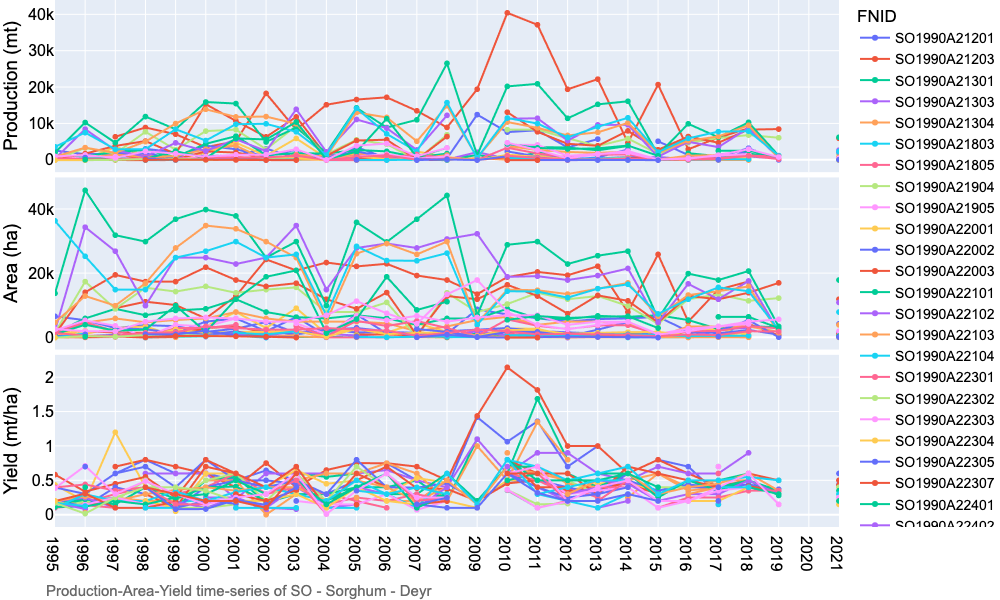

In [8]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'SO', 'Somalia'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [1995, df['year'].max()]
product_season = [
    ['Maize','Gu'],
    ['Maize','Deyr'],
    ['Sorghum','Gu'],
    ['Sorghum','Deyr'],    
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_lineplot_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()